<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Transfer-Learning" data-toc-modified-id="Transfer-Learning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Transfer Learning</a></span></li><li><span><a href="#Loading-a-pre-trained-CNN" data-toc-modified-id="Loading-a-pre-trained-CNN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading a pre-trained CNN</a></span></li><li><span><a href="#Testing-the-pre-trained-CNN" data-toc-modified-id="Testing-the-pre-trained-CNN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Testing the pre-trained CNN</a></span></li><li><span><a href="#Which-classes-does-this-model-know-at-all?" data-toc-modified-id="Which-classes-does-this-model-know-at-all?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Which classes does this model know at all?</a></span></li></ul></div>

# Transfer Learning

Transfer learning means that we do not train a CNN from scratch. Instead, we take one that was already trained before, typically on a huge dataset. Then we try to make use of the feature hierarchy that already exists.

# Loading a pre-trained CNN

In Keras there are several pre-trained CNNs available. A list of pre-trained CNNs is available [here](https://keras.io/applications/). At time of writing these lines (April 2019), the following pre-trained CNNs were directly supported by Keras:

- Xception
- VGG16
- VGG19
- ResNet, ResNetV2, ResNeXt
- InceptionV3
- InceptionResNetV2
- MobileNet
- MobileNetV2
- DenseNet
- NASNet

In the following we will try to learn VGG16.

In [1]:
from keras.applications import VGG16

my_model = VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))

my_model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

In [3]:
print("Number of layers:", len(my_model.layers))

print("Here are the names of all layers:")
nr_conv_layers = 0
nr_pool_layers = 0
for layer in my_model.layers:
    print(layer.name)
    if "conv" in layer.name:
        nr_conv_layers+=1
    if "pool" in layer.name:
        nr_pool_layers+=1

print("\nSummary:")
print("\tNr of conv layers:", nr_conv_layers)
print("\tNr of pool layers:", nr_pool_layers)

Number of layers: 23
Here are the names of all layers:
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten
fc1
fc2
predictions

Summary:
	Nr of conv layers: 13
	Nr of pool layers: 5


Now let us plot the model graphically to an image saved to disk:

In [17]:
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import cv2

model_fname = "model_visu.png"

plot_model(my_model,
           to_file=model_fname,
           show_shapes=True,
           show_layer_names=True)

# Testing the pre-trained CNN

Let's try to classify an image with this CNN!

In [30]:
import numpy as np
import cv2
import os
from os import listdir
from os.path import isdir, isfile, join

IMG_SIZE = (224,224)
    
class image_provider:
    
    #
    # Traverses all subfolders of the specified root_folder
    # and generates a list of the form:
    #
    # [ ["data/bikes/jfksdj43.jpg", "bikes",
    #   ["data/cars/bvcnm401.jpg", "cars"],
    #   ...
    # ]
    #
    def __init__(self, root_folder):
        
        self.all_training_items = []
       
        self.class_names = \
            [d for d in listdir(root_folder)
             if isdir(os.path.join(root_folder,d))]

        print("Under folder\n\t", root_folder,
              "\nI found the following subfolders/classes:")
        print(self.class_names)
        
        self.nr_classes = len(self.class_names)
        
        # For each subfolder ...
        for class_id, class_name in enumerate(self.class_names):
            
            subfolder_name = root_folder + "/" + class_name + "/"
            
            filenames = \
                [subfolder_name + f
                 for f in listdir(subfolder_name)
                 if isfile(join(subfolder_name, f))]
            
            print("{} files in subfolder {}".format(len(filenames),
                                                    subfolder_name) )
            
            # For each image filename in current subfolder ...
            for filename in filenames:
                
                teacher_vec = np.zeros( self.nr_classes )
                teacher_vec[class_id] = 1.0
                
                self.all_training_items.append(
                    [filename, class_id, class_name, teacher_vec] )              
        
        self.nr_images = len(self.all_training_items)
        print("There are {} images in total available.".format(self.nr_images))
        
        print("Here are the first 3 entries of the training items list generated:")
        print(self.all_training_items[:3])
        
    
    
    #   
    # Given an absolute filename,
    # load the image in using OpenCV,
    # then convert it to usual RGB color channel order
    # and scale values to be in range [0,1]
    #
    def load_image(self, absolute_filename):
        
        image = cv2.imread(absolute_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
        image = cv2.resize(image, IMG_SIZE, interpolation=cv2.INTER_AREA)
        #image = image * (1.0 / 255.0)
        
        return image
        
        
       
    #
    # Return the image from the dataset
    # with the specified index
    #
    def get_specific_image(self, idx):
        
        image_filename  = self.all_training_items[idx][0]
        class_id        = self.all_training_items[idx][1]
        class_name      = self.all_training_items[idx][2]
        teacher_vec     = self.all_training_items[idx][3]
        
        image = self.load_image(image_filename)
        
        return image, class_id, class_name, teacher_vec
    
    
    #
    # Return an OpenCV image and the class label
    # where the image is chosen randomly from the
    # list of all images.
    #
    def get_random_image(self):
        
        rnd_idx = np.random.randint(0, self.nr_images)
        return self.get_specific_image( rnd_idx )

Let us create an image provider that can provide us test images:

In [65]:
data_folder = "V:\\01_job\\12_datasets\\test_images_for_img_classification"
img_provider = image_provider( data_folder )

Under folder
	 V:\01_job\12_datasets\test_images_for_img_classification 
I found the following subfolders/classes:
['misc']
14 files in subfolder V:\01_job\12_datasets\test_images_for_img_classification/misc/
There are 14 images in total available.
Here are the first 3 entries of the training items list generated:
[['V:\\01_job\\12_datasets\\test_images_for_img_classification/misc/autumn.jpg', 0, 'misc', array([1.])], ['V:\\01_job\\12_datasets\\test_images_for_img_classification/misc/balls_and_baby_head.jpg', 0, 'misc', array([1.])], ['V:\\01_job\\12_datasets\\test_images_for_img_classification/misc/car_and_persons.jpg', 0, 'misc', array([1.])]]


Now let us retrieve test images and classify them using the pre-trained CNN:

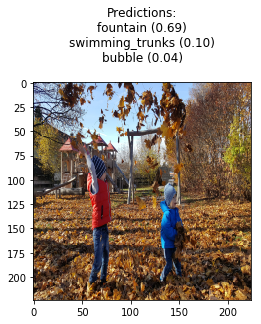

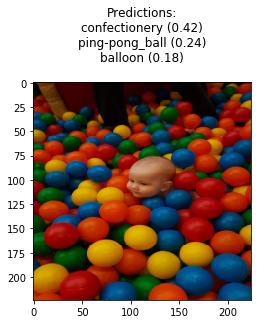

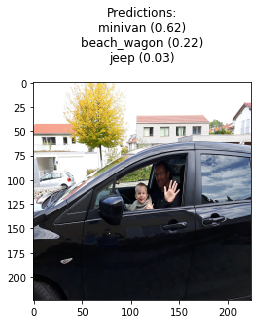

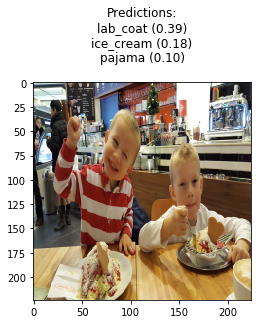

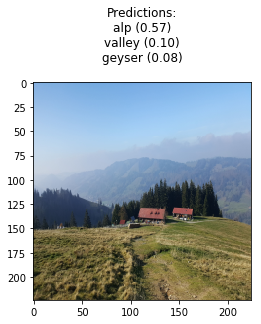

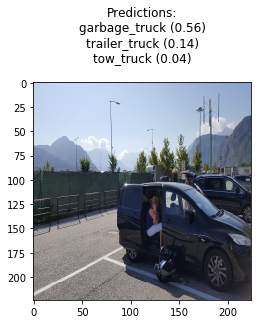

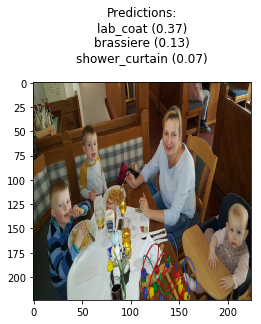

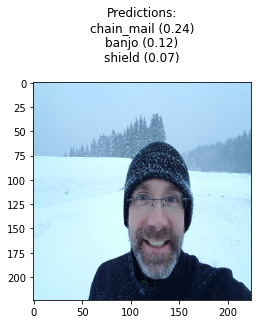

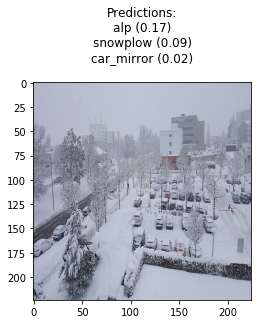

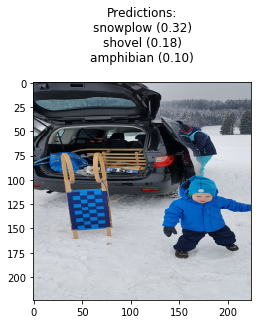

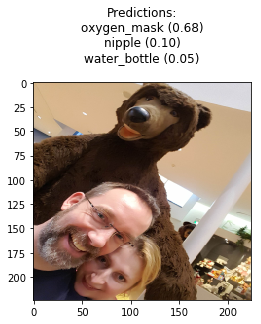

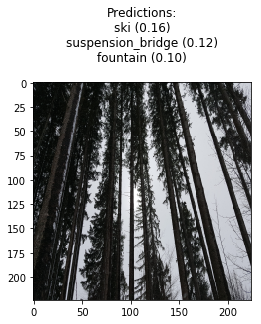

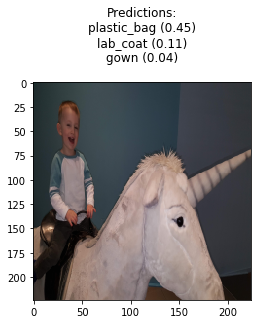

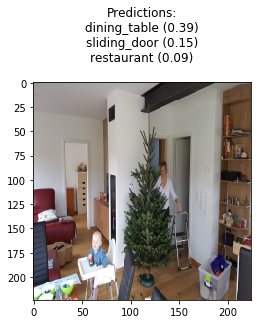

In [72]:
from keras.applications.vgg16 import decode_predictions

for img_nr in range(0, img_provider.nr_images):

    image, class_id, class_name, teacher_vec = \
        img_provider.get_specific_image( img_nr )

    THE_INPUT_IMG_SHAPE = image.shape

    #print("image has type", type(image))
    #print("image has shape", image.shape)    
    
    height = image.shape[0]
    width  = image.shape[1]
    nr_channels = image.shape[2]
    X = np.zeros( (1,height,width,nr_channels) )

    X[0,:,:,:] = image

    neuron_outputs = my_model.predict( X )
    #print(neuron_outputs[0,:10])

    # decode the results into a list of tuples (class, description, probability)
    pred_classes_and_probs = decode_predictions(neuron_outputs, top=3)[0]    
    img_title = "Predictions:\n"
    for (x,y,z) in pred_classes_and_probs:
        img_title += "{} ({:.2f})\n".format(y,z)
        
    plt.imshow(image)
    plt.title(img_title)
    plt.show()


# Which classes does this model know at all?

In [60]:
all_class_probs = decode_predictions(neuron_outputs, top=1000)[0]
print(all_class_probs[0:10])
list_class_names = [y for (x,y,z) in all_class_probs]
print(list_class_names[0:10])

counter = 0
for class_name in list_class_names:
    print("{:40}".format(class_name), end="\t")


[('n04461696', 'tow_truck', 0.4616116), ('n03930630', 'pickup', 0.21887867), ('n03777568', 'Model_T', 0.15346788), ('n03478589', 'half_track', 0.033155624), ('n03670208', 'limousine', 0.015136801), ('n03345487', 'fire_engine', 0.011068713), ('n02930766', 'cab', 0.010281453), ('n02974003', 'car_wheel', 0.009631965), ('n03895866', 'passenger_car', 0.008465006), ('n03417042', 'garbage_truck', 0.008176445)]
['tow_truck', 'pickup', 'Model_T', 'half_track', 'limousine', 'fire_engine', 'cab', 'car_wheel', 'passenger_car', 'garbage_truck']
tow_truck                               	pickup                                  	Model_T                                 	half_track                              	limousine                               	fire_engine                             	cab                                     	car_wheel                               	passenger_car                           	garbage_truck                           	minibus                                 	moving_van 